# MACHINE LEARNING - CLAIMS FORECASTING

## Introduction

The goal of the project is to predict the expected number of motor insurance claims for each policy during its exposure period.

The dataset provided contains information of almost 680,000 motor insurance policies, including characteristics related to: the policyholder, the vehicle or the geographical location.

The objective of this notebook is to:
- Perform a thorough exploratory data analysis (EDA).
- Engineer meaningful features that improve predictive performance.
- Build and compare two modeling approaches:
    - A Generalized Linear Model (Poisson or Tweedie),
    - A machine-learning model based on decision trees (XGBoost).
- Evaluate and interpret the models from both a statistical and business perspective.
- Provide insights and recommendations useful for pricing and risk management.

## Data loading and cleaning

In [71]:
# This ensures that XGBoost is installed in the same Python environment as the Jupyter kernel.

import sys
!{sys.executable} -m pip install xgboost



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

df = pd.read_csv(r"C:\Users\garcajosantonio\Desktop\Ominimo_project\freMTPL2freq.csv")


In [ ]:
# Quick first overview of the dataset
df.head(20)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72
5,13.0,1,0.52,E,6,2,38,50,B12,Regular,3003,R31
6,15.0,1,0.45,E,6,2,38,50,B12,Regular,3003,R31
7,17.0,1,0.27,C,7,0,33,68,B12,Diesel,137,R91
8,18.0,1,0.71,C,7,0,33,68,B12,Diesel,137,R91
9,21.0,1,0.15,B,7,0,41,50,B12,Diesel,60,R52


In [ ]:
# Checking number the dimension of the dataset
df.shape


(678013, 12)

In [ ]:
# Checking the type of data that we have.
df.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

In [ ]:
# Checking base statistical characteristics.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [ ]:
# Other way to check the nulls
df.isna().sum()


IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [ ]:
# Checking duplicates
df.duplicated().sum()

np.int64(0)

After checking for duplicates and missing values, none were found in the dataset.  
All columns are complete and consistent. 

## Exploratory Data Analysis - EDA

#### Exploring the feature ClaimNb (target)

It's a count variable so we need to expect values like 0, 1, 2... Normally, most of the people won't have any claim so the distribution will be right skewed. 

Before modeling, it is important to:
- Check its distribution.
- Evaluate how many policies have at least one claim.
- Inspect extreme values and data errors like negative values in this case.

In [79]:
df["ClaimNb"].describe()

count    678013.000000
mean          0.053247
std           0.240117
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: ClaimNb, dtype: float64

Here we can see that there is no negative values and the mean is very close to 0 so most of the values will be 0. Moreover, we can see that that at least the 75% of the values are 0 because of the percentil. Finally, we have at least one policy with 16 claims which doesn't look normal. 

In [80]:
df["ClaimNb"].value_counts().sort_index()

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
5          2
6          1
8          1
9          1
11         3
16         1
Name: count, dtype: int64

By checking the value counts of the target (ClaimNb), we observe that more than 640,000 policies (over 95%) have zero claims.
Around 32,000 policies reported one claim, while only a few reported two or more.
A very small number of policies show extremely high values such as 8, 9, 11, or even 16 claims.
This fact confirms what I supposed at the beggining, the distributition is hihgly right skewed.

In [81]:
(df["ClaimNb"] > 0).mean()

np.float64(0.05023502499214617)

Only the 5% of the polocies have at least one claim.

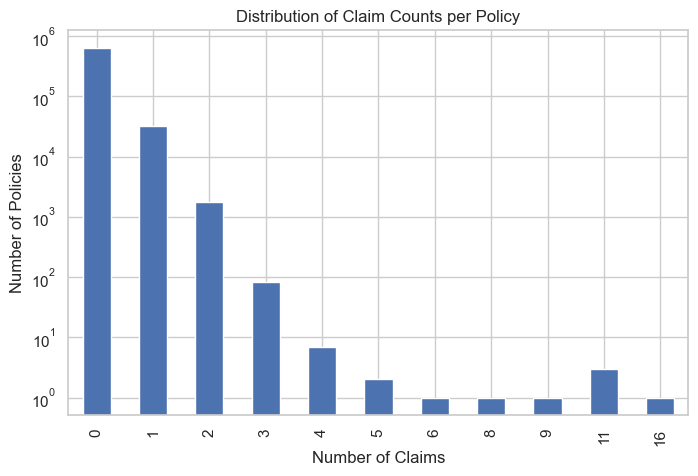

In [82]:
plt.figure(figsize=(8,5))
df["ClaimNb"].value_counts().sort_index().plot(kind="bar", logy= True)
plt.title("Distribution of Claim Counts per Policy")
plt.xlabel("Number of Claims")
plt.ylabel("Number of Policies")
plt.show()

The chart above shows how many claims each policy had.
Most policies have zero claims, and only a small number have one.
Very few policies have more than one claim.
This means the data is not balanced, most values are zero and only a few are large.
Because of this, count models like Poisson is good choice for this kind of problem.


#### Univariate Analysis

##### Numerical variable

In [ ]:
# Creating a list with numerical features for later on, check the main statistical characteristics for each one.
numerical_cols = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
df[numerical_cols].describe()


,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


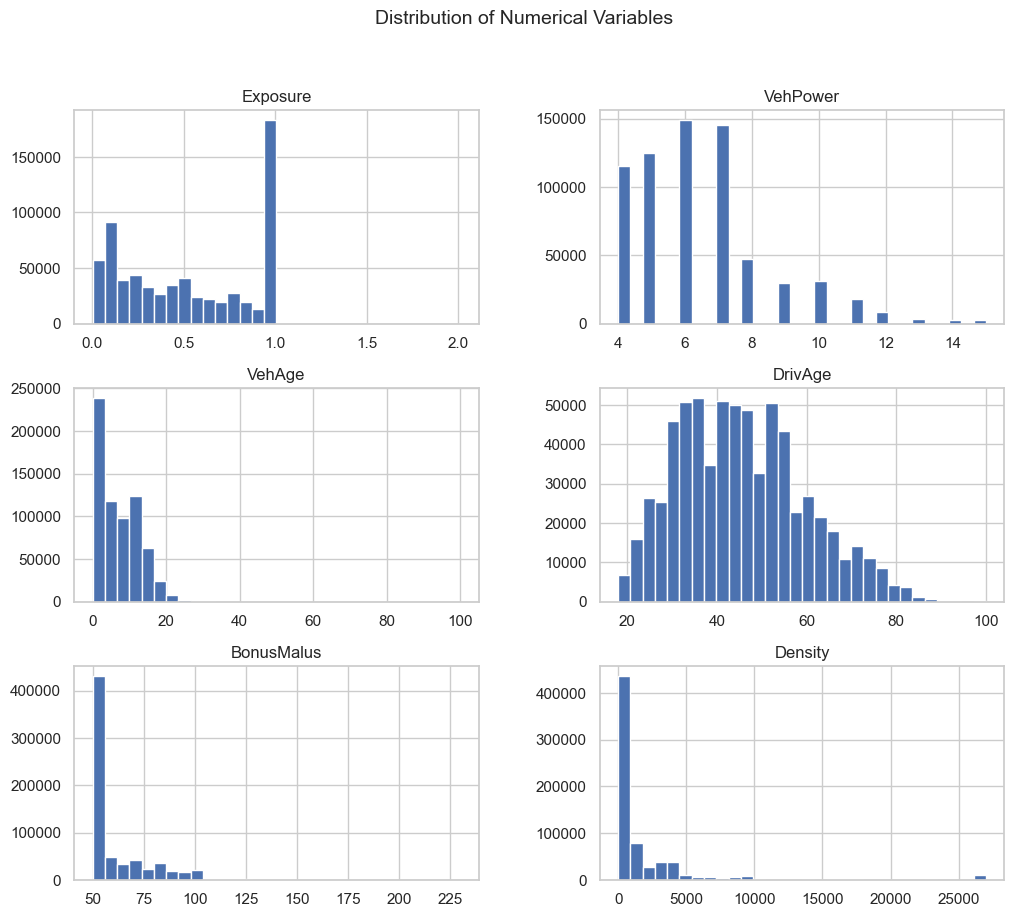

In [84]:
df[numerical_cols].hist(figsize=(12,10), bins=30)
plt.suptitle("Distribution of Numerical Variables", fontsize=14)
plt.show()

The table above shows the main statistics for all numerical variables in the dataset.

- **Exposure:**
  The average exposure is around 0.53 years (about 193 days), which means most policies lasted less than one full year.
  The minimum values are very small, probably due to early cancellations or short contracts.
  Exposure is important because it shows how long a policy was active, and policies with longer exposure have more chances to report a claim.

- **VehPower:**
  The vehicle power is centered around 6.5, with most cars between 4 and 7.
  A few vehicles have higher power (up to 15), which may indicate sports or luxury cars.

- **VehAge:**
  The average vehicle age is around 7 years.
  Most cars are between 2 and 11 years old, but there are a few very old vehicles (even 100 years), probably classic cars.

- **DrivAge:**
  The average driver age is around 45 years, which is realistic.
  The youngest drivers are 18, while the oldest are 100, suggesting that some extreme values might need review.

- **BonusMalus:**
  The average value is about 60, which means most policyholders are in a “bonus” situation (below 100).
  The minimum is 50, and the maximum is 230, showing a wide range of risk profiles.

- **Density:**
  This variable is highly skewed, with most drivers living in areas below 2000 inhabitants/km²,
  but a few live in very dense regions (up to 27,000).
  This confirms that population density varies strongly by area and could influence the claim rate.

Overall, most numerical variables show right-skewed distributions and contain some outliers, which is typical for insurance data.


##### Categorical features

In [ ]:
# Creating a list with the categorical features for later on, see how representative is each category in
# it's variable.
categorical_cols = ["Area", "VehBrand", "VehGas", "Region"]
for col in categorical_cols:
    print(f"\n{col} value counts:\n")
    print(df[col].value_counts(normalize=True))



Area value counts:

Area
C    0.283003
D    0.223589
E    0.202307
A    0.153326
B    0.111294
F    0.026480
Name: proportion, dtype: float64

VehBrand value counts:

VehBrand
B12    0.244868
B1     0.240019
B2     0.235779
B3     0.078752
B5     0.051257
B6     0.042105
B4     0.037136
B10    0.026116
B11    0.020036
B13    0.017961
B14    0.005969
Name: proportion, dtype: float64

VehGas value counts:

VehGas
Regular    0.510133
Diesel     0.489867
Name: proportion, dtype: float64

Region value counts:

Region
R24    0.236870
R82    0.125001
R93    0.116982
R11    0.102935
R53    0.062126
R52    0.057154
R91    0.052809
R72    0.046207
R31    0.040243
R54    0.028091
R73    0.025281
R41    0.019159
R25    0.016066
R26    0.015475
R23    0.012956
R22    0.011790
R83    0.007798
R74    0.006736
R94    0.006661
R21    0.004463
R42    0.003245
R43    0.001956
Name: proportion, dtype: float64


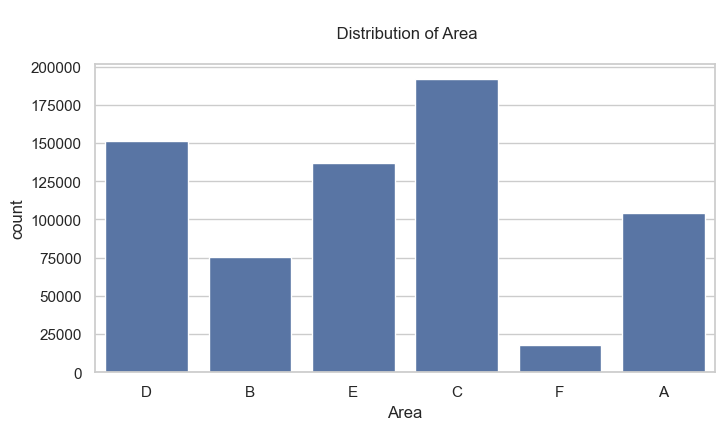

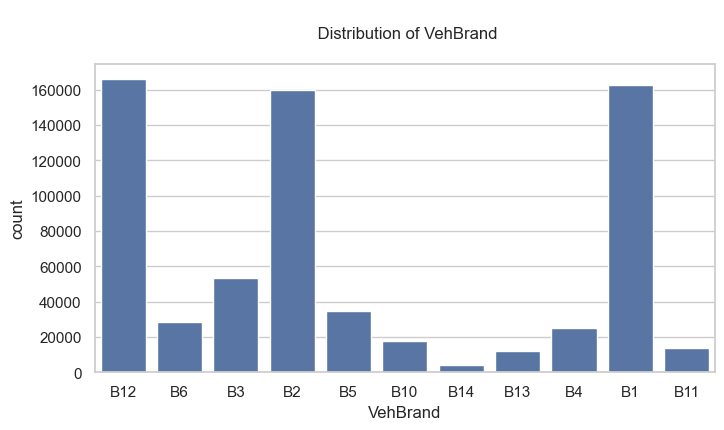

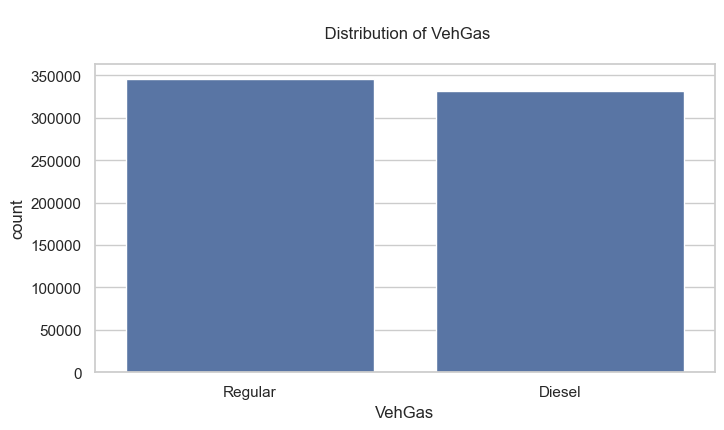

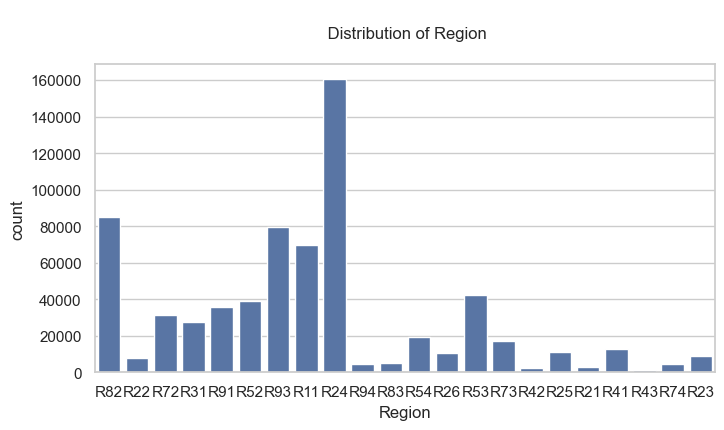

In [ ]:
# Representing categorical columns.
for col in categorical_cols:

    plt.figure(figsize=(8,4))
    sns.countplot(x= col, data=df)
    plt.title(f"\n Distribution of {col}\n")
    plt.show()

- **Area:**
  Most policies come from Areas C, D, and E, which together make up more than 70% of the portfolio.  
  Area F is the smallest group (around 2.6%).

- **VehBrand:**
  The main brands B12, B1, and B2 are the most common, representing more than 70% of the vehicles.  
  Other brands have fewer records, such as B14 with less than 1%.

- **VehGas:**
  The fuel type is almost balanced, with 51% Regular and 49% Diesel.

- **Region:**
  There are many regions in the dataset, but a few dominate.  
  Region R24 is the largest (around 24%), while regions like R42 and R43 have very few policies (less than 1%).  
  This shows that the portfolio covers the entire country but with unequal representation.

In general, the categorical variables are not strongly imbalanced, except for some regions and vehicle brands that appear less frequently.


#### Bivariate Analysis (comparing the target with others variables)

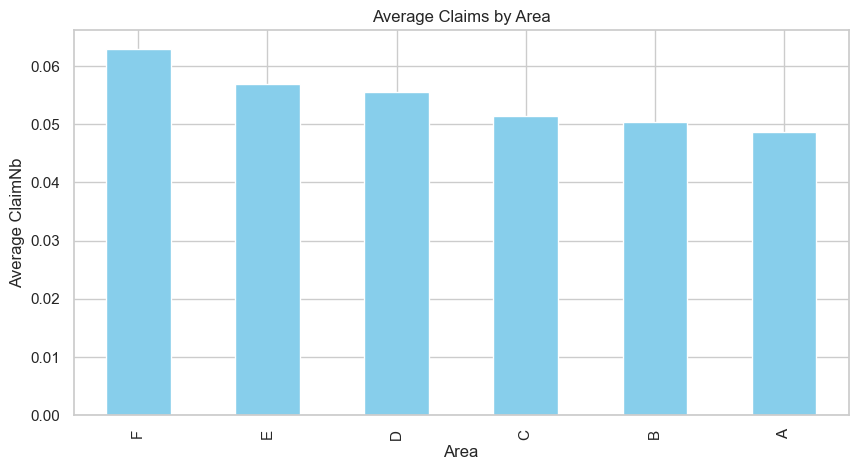

In [87]:
df.groupby("Area")["ClaimNb"].mean().sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Average Claims by Area")
plt.ylabel("Average ClaimNb")
plt.show()


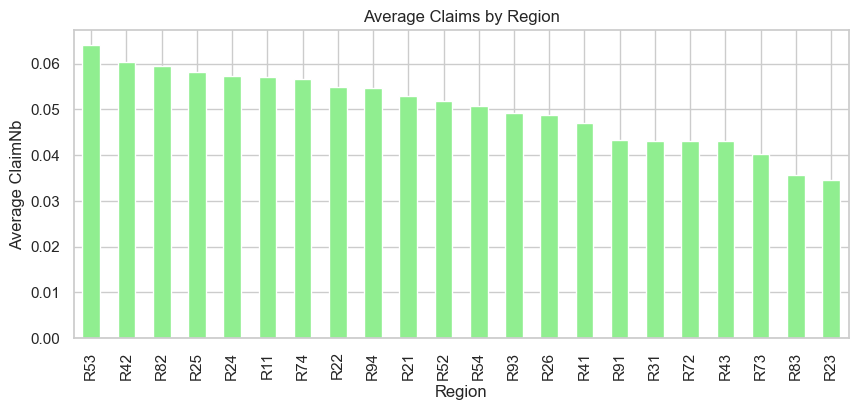

In [88]:
df.groupby("Region")["ClaimNb"].mean().sort_values(ascending=False).plot(kind="bar", figsize=(10,4), color="lightgreen")
plt.title("Average Claims by Region")
plt.ylabel("Average ClaimNb")
plt.show()

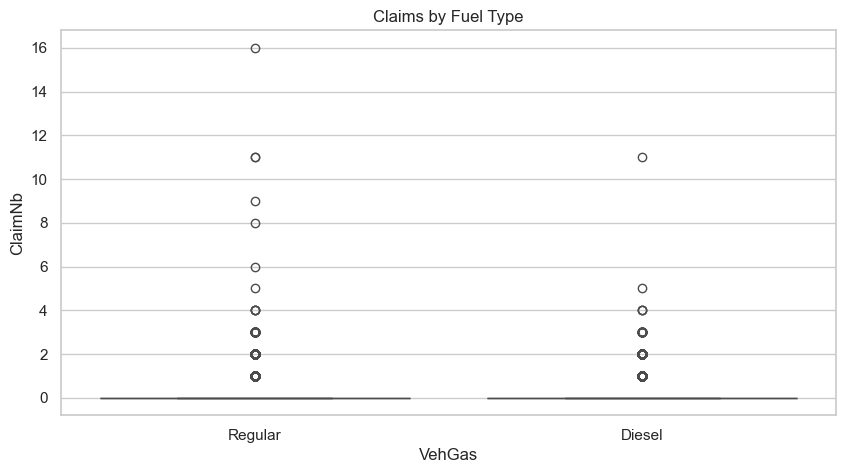

In [89]:
sns.boxplot(x="VehGas", y="ClaimNb", data=df)
plt.title("Claims by Fuel Type")
plt.show()


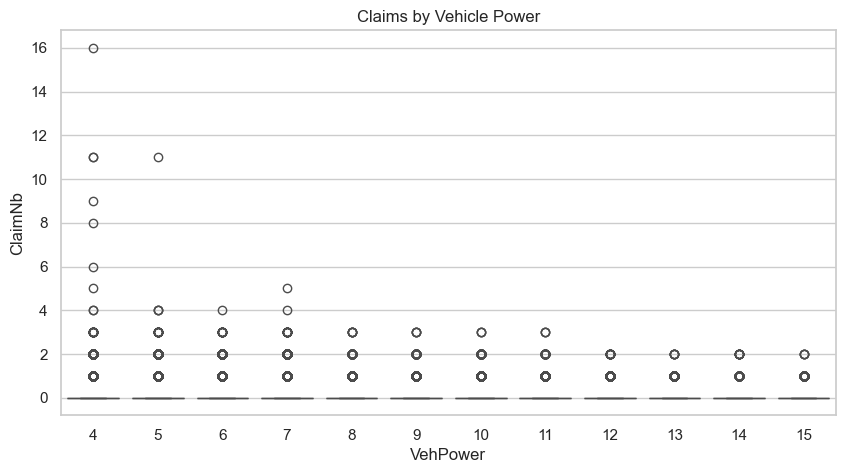

In [90]:
sns.boxplot(x="VehPower", y="ClaimNb", data=df)
plt.title("Claims by Vehicle Power")
plt.show()


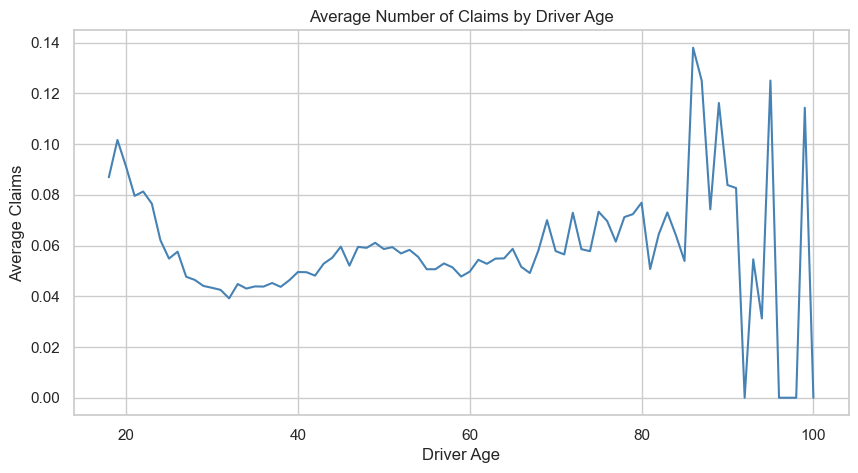

In [142]:
# Average number of claims by driver age
claims_by_age = df.groupby("DrivAge")["ClaimNb"].mean()

plt.figure(figsize=(10,5))
plt.plot(claims_by_age.index, claims_by_age.values, color="steelblue")
plt.title("Average Number of Claims by Driver Age")
plt.xlabel("Driver Age")
plt.ylabel("Average Claims")
plt.show()


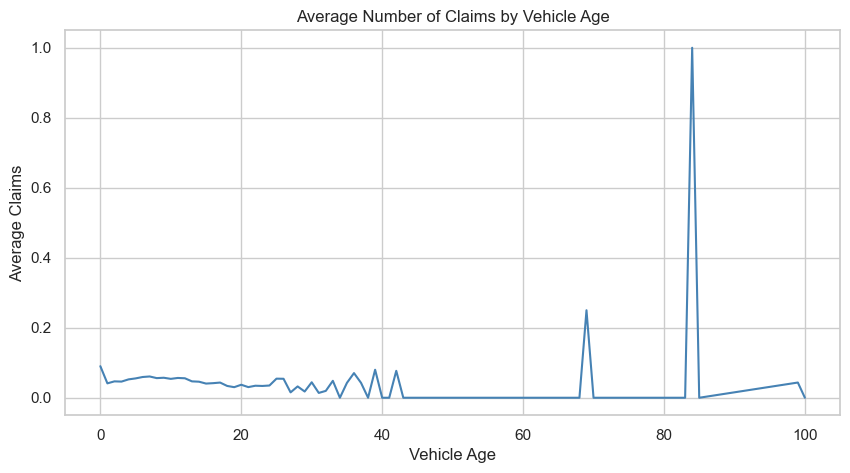

In [144]:
vehage_claims = df.groupby("VehAge")["ClaimNb"].mean()

plt.figure(figsize=(10,5))
plt.plot(vehage_claims.index, vehage_claims.values, color="steelblue")
plt.title("Average Number of Claims by Vehicle Age")
plt.xlabel("Vehicle Age")
plt.ylabel("Average Claims")
plt.show()


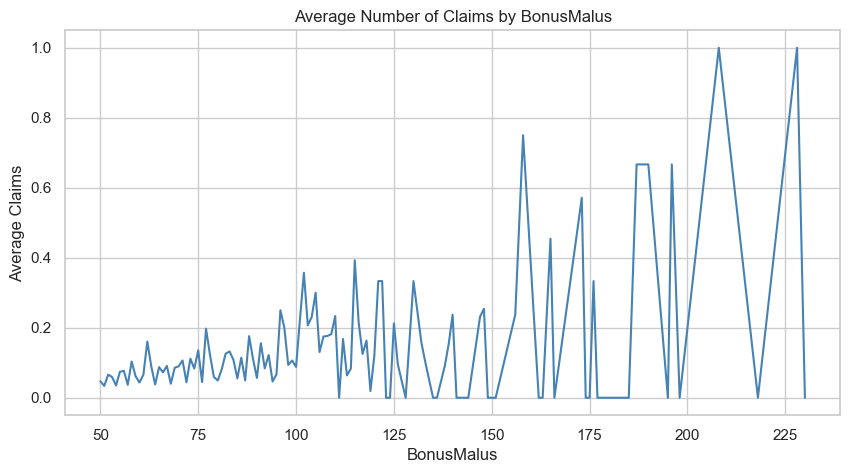

In [143]:
bonus_claims = df.groupby("BonusMalus")["ClaimNb"].mean()

plt.figure(figsize=(10,5))
plt.plot(bonus_claims.index, bonus_claims.values, color="steelblue")
plt.title("Average Number of Claims by BonusMalus")
plt.xlabel("BonusMalus")
plt.ylabel("Average Claims")
plt.show()


The charts above show how the number of claims changes with the main variables.

- **Area:**
 Area F has the highest average number of claims, and Area A the lowest. This can be related to traffic or population differences between areas.

- **Region:**
 Some regions, like R53 and R42, have higher average claims. Others show much lower values, which means location may play an important role.

- **Fuel Type:**
 Both Regular and Diesel cars have very similar claim numbers. Fuel type does not seem to affect the chance of having a claim.

- **Vehicle Power:**
 There is no clear trend between vehicle age and claims. Most cars have a similar number of claims, and the peaks for very old vehicles are likely because there are few of them in the data.

- **Driver Age:**
 The average number of claims is relatively stable between ages 30 and 60, suggesting that middle-aged drivers generate most of the claims. Younger drivers (<25) and older ones (>70) show more variability, possibly due to fewer observations or different driving patterns.

- **Vehicle Age:**
 Newer cars have fewer claims, while older cars show slightly higher values. This makes sense because older cars might be used more or have fewer safety features.

- **BonusMalus:**
 The plot shows that as the BonusMalus value increases, the average number of claims also tends to rise. This means that drivers with higher penalty levels (malus) are more likely to have claims, confirming that the BonusMalus variable reflects driver risk well. The variability at higher values may be due to fewer observations in those ranges.

In general, we can see that location, driver age, and the BonusMalus factor are related to the number of claims. These insights can be useful for creating new features during the feature engineering step.


## FEATURE ENGINEERING

In this part, I create new variables to help the model learn better patterns from the data.  
The goal is to add information that can explain why some policies have more claims than others.  

These new features come from the variables we already have, such as exposure time, driver age, vehicle characteristics, and location.  
By creating these new columns, we try to make the model more accurate and easier to interpret.


In [94]:
# I will pass the exposure to days in case I need it later.
df["Exposure_Days"]=df["Exposure"]*365

In [95]:
df.head(20)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure_Days
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,36.50
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,281.05
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,273.75
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,32.85
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,306.60
5,13.0,1,0.52,E,6,2,38,50,B12,Regular,3003,R31,189.80
6,15.0,1,0.45,E,6,2,38,50,B12,Regular,3003,R31,164.25
7,17.0,1,0.27,C,7,0,33,68,B12,Diesel,137,R91,98.55
8,18.0,1,0.71,C,7,0,33,68,B12,Diesel,137,R91,259.15
9,21.0,1,0.15,B,7,0,41,50,B12,Diesel,60,R52,54.75


In [96]:
# By default, the new column (feature) is created at the end, so I am going to move it where I want.

col = df.pop("Exposure_Days")
pos = df.columns.get_loc("Exposure") + 1
df.insert(pos, "Exposure_Days", col)

In [97]:
df.head(20)

,IDpol,ClaimNb,Exposure,Exposure_Days,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,36.50,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,281.05,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,273.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,32.85,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,306.60,B,7,0,46,50,B12,Diesel,76,R72
5,13.0,1,0.52,189.80,E,6,2,38,50,B12,Regular,3003,R31
6,15.0,1,0.45,164.25,E,6,2,38,50,B12,Regular,3003,R31
7,17.0,1,0.27,98.55,C,7,0,33,68,B12,Diesel,137,R91
8,18.0,1,0.71,259.15,C,7,0,33,68,B12,Diesel,137,R91
9,21.0,1,0.15,54.75,B,7,0,41,50,B12,Diesel,60,R52


In [98]:
# I am going to create another column for people who cancel or not the policy.
# In case they did, if it was after renew one or more policies or if it was during the first policy year.

# If the person last exactly until the lenght of the policy. 

df["Cancellation_Stage"] = 0

# Cancellation during the first year.
df.loc[df["Exposure_Days"] < 365, "Cancellation_Stage"] = 1

# Cancellation after at least one renewal.
df.loc[
    (df["Exposure_Days"] >= 365) & (df["Exposure_Days"] % 365 != 0),
    "Cancellation_Stage"
] = 2


In [99]:
df.head(10)

,IDpol,ClaimNb,Exposure,Exposure_Days,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Cancellation_Stage
0,1.0,1,0.10,36.50,D,5,0,55,50,B12,Regular,1217,R82,1
1,3.0,1,0.77,281.05,D,5,0,55,50,B12,Regular,1217,R82,1
2,5.0,1,0.75,273.75,B,6,2,52,50,B12,Diesel,54,R22,1
3,10.0,1,0.09,32.85,B,7,0,46,50,B12,Diesel,76,R72,1
4,11.0,1,0.84,306.60,B,7,0,46,50,B12,Diesel,76,R72,1
5,13.0,1,0.52,189.80,E,6,2,38,50,B12,Regular,3003,R31,1
6,15.0,1,0.45,164.25,E,6,2,38,50,B12,Regular,3003,R31,1
7,17.0,1,0.27,98.55,C,7,0,33,68,B12,Diesel,137,R91,1
8,18.0,1,0.71,259.15,C,7,0,33,68,B12,Diesel,137,R91,1
9,21.0,1,0.15,54.75,B,7,0,41,50,B12,Diesel,60,R52,1


In [100]:
# Getting sure that everything was created correctly.

df["Cancellation_Stage"].unique()

array([1, 0, 2])

In [101]:
# Creating a new feature for the different cities in the dataset.

city_key = df["Area"].astype(str) + "_" + df["Region"].astype(str)
df["CityID"] = city_key.astype("category").cat.codes


In [103]:
df["CityID"].nunique()

109

In [104]:
# Creating DensityClass by dividing the density into quantiles perfectly distributed.

df["DensityClass"] = pd.qcut(df["Density"], q=3, labels=["low", "medium", "high"])


In [105]:
df["DensityClass"].nunique()

3

In [106]:
# Here I am calculating the risk of claims per city.

city_freq = (
    df.groupby("CityID")["ClaimNb"].sum() /
    df.groupby("CityID")["Exposure"].sum()
)

df["CityRisk"] = df["CityID"].map(city_freq)


In [145]:
df.head(10)

,IDpol,ClaimNb,Exposure,Exposure_Days,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,...,DensityClass,CityRisk,DriverAgeBand,VehAgeClass,BrandRisk,PowerRisk,RegionRisk,Bonus_Class,Relation_DriverVeh,Relation_PowerAgeVeh
0,1.0,1,0.10,36.50,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
1,3.0,1,0.77,281.05,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
2,5.0,1,0.75,273.75,B,6,2,52,50,B12,...,low,0.107895,senior,new,0.136695,0.101558,0.122817,bonus,104,12
3,10.0,1,0.09,32.85,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
4,11.0,1,0.84,306.60,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
5,13.0,1,0.52,189.80,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
6,15.0,1,0.45,164.25,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
7,17.0,1,0.27,98.55,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
8,18.0,1,0.71,259.15,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
9,21.0,1,0.15,54.75,B,7,0,41,50,B12,...,low,0.076053,adult,new,0.136695,0.097844,0.091638,bonus,0,0


In [108]:
# Calculating the city with the maximun and the minimun risk of collision.

print(df.loc[df["CityRisk"].idxmax(), ["CityID", "CityRisk"]])
print(df.loc[df["CityRisk"].idxmin(), ["CityID", "CityRisk"]])


CityID            98
CityRisk    0.203327
Name: 2059, dtype: object
CityID            32
CityRisk    0.060471
Name: 2611, dtype: object


In [109]:
# Creating a new feature where I group drivers by ages.
# young - under 25 yo
# young_adult - between 25-35 yo
# adult - between 35-50 yo
# senior - between 50-65 yo
# super_senior - over 65 yo

df["DriverAgeBand"] = pd.cut(
    df["DrivAge"],
    bins=[-float("inf"), 25, 35, 50, 65, float("inf")],
    labels=["young", "young_adult", "adult", "senior", "super_senior"]
)


In [110]:
# Creating a new feature where I group cars by ages.
# between 0-5
# between 5-10 yo
# between 10-20 yo
# between 20-30 yo
# Over 30 yo

df["VehAgeClass"] = pd.cut(
    df["VehAge"],
    bins=[-1, 5, 10, 20, 30, df["VehAge"].max()],
    labels=["new", "pre_owned", "old", "very_old", "classic"]
)


In [111]:
# Here I am calculating the risk of claims per brand.

brand_freq = (
    df.groupby("VehBrand")["ClaimNb"].sum() /
    df.groupby("VehBrand")["Exposure"].sum()
)

df["BrandRisk"] = df["VehBrand"].map(brand_freq)



In [112]:
# Here I am calculating the risk of claims per power.

power_freq = (
    df.groupby("VehPower")["ClaimNb"].sum() /
    df.groupby("VehPower")["Exposure"].sum()
)

df["PowerRisk"] = df["VehPower"].map(power_freq)


In [113]:
# Here I am calculating the risk of claims per region.
region_freq = (
    df.groupby("Region")["ClaimNb"].sum() /
    df.groupby("Region")["Exposure"].sum()
)
df["RegionRisk"] = df["Region"].map(region_freq)


In [146]:
df.head(10)

,IDpol,ClaimNb,Exposure,Exposure_Days,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,...,DensityClass,CityRisk,DriverAgeBand,VehAgeClass,BrandRisk,PowerRisk,RegionRisk,Bonus_Class,Relation_DriverVeh,Relation_PowerAgeVeh
0,1.0,1,0.10,36.50,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
1,3.0,1,0.77,281.05,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
2,5.0,1,0.75,273.75,B,6,2,52,50,B12,...,low,0.107895,senior,new,0.136695,0.101558,0.122817,bonus,104,12
3,10.0,1,0.09,32.85,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
4,11.0,1,0.84,306.60,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
5,13.0,1,0.52,189.80,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
6,15.0,1,0.45,164.25,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
7,17.0,1,0.27,98.55,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
8,18.0,1,0.71,259.15,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
9,21.0,1,0.15,54.75,B,7,0,41,50,B12,...,low,0.076053,adult,new,0.136695,0.097844,0.091638,bonus,0,0


In [115]:
#df["Bonus_Class"] = pd.cut(
#    df["BonusMalus"],
#    bins=[df["BonusMalus"].min(), 100,100, df["BonusMalus"].max()],
#    labels=["Bonus", "Neutral", "Malus"],
#    include_lowest=True
#)

# I have tried to implement the same way to do the clustering with the feature BonusMalus 
# but python doesn't allow to have two limits with the same number.

In [116]:
# Alternatively, I have searched and with Numpy I can implement this code that is doing the same job.

conditions = [
    df["BonusMalus"] < 100,
    df["BonusMalus"] == 100,
    df["BonusMalus"] > 100
]

different_classes = ["bonus", "neutral", "malus"]

df["Bonus_Class"] = np.select(conditions, different_classes,default="bonus")


In [117]:
df["Bonus_Class"].value_counts()

Bonus_Class
bonus      650689
neutral     19530
malus        7794
Name: count, dtype: int64

In [118]:
df.shape

(678013, 23)

In [ ]:
# I am going to create 2 more features combining DrivAge and VehAge and the second one, VehPower and VehAge.
# Then, when for using XGBoost the model can realize about different patterns depending on the age of the people and vehicle. 
# For example, my intention is that the model realize that young people or super old people with and old car or a classic,
# normally have more chances to make a claim.

df["Relation_DriverVeh"] = df["DrivAge"] * df["VehAge"]

df["Relation_PowerAgeVeh"] = df["VehPower"] * df["VehAge"]



In [120]:
# IMPORTANT: When VehAge = 0 (a new car), the interaction DriverAge × VehAge becomes 0.
# This does not harm the model, because XGBoost still uses DriverAge and VehAge as separate features.
# The interaction is only meant to capture additional risk when both the driver and the car contribute together
# (for example, young or older drivers with old vehicles).
# If the car is new, the model still evaluates the driver's age normally, so a zero interaction value does not remove risk.

In [147]:
df.head(10)

,IDpol,ClaimNb,Exposure,Exposure_Days,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,...,DensityClass,CityRisk,DriverAgeBand,VehAgeClass,BrandRisk,PowerRisk,RegionRisk,Bonus_Class,Relation_DriverVeh,Relation_PowerAgeVeh
0,1.0,1,0.10,36.50,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
1,3.0,1,0.77,281.05,D,5,0,55,50,B12,...,high,0.123191,senior,new,0.136695,0.106757,0.110966,bonus,0,0
2,5.0,1,0.75,273.75,B,6,2,52,50,B12,...,low,0.107895,senior,new,0.136695,0.101558,0.122817,bonus,104,12
3,10.0,1,0.09,32.85,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
4,11.0,1,0.84,306.60,B,7,0,46,50,B12,...,low,0.095402,adult,new,0.136695,0.097844,0.094120,bonus,0,0
5,13.0,1,0.52,189.80,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
6,15.0,1,0.45,164.25,E,6,2,38,50,B12,...,high,0.122233,adult,new,0.136695,0.101558,0.102279,bonus,76,12
7,17.0,1,0.27,98.55,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
8,18.0,1,0.71,259.15,C,7,0,33,68,B12,...,low,0.094986,young_adult,new,0.136695,0.097844,0.104980,bonus,0,0
9,21.0,1,0.15,54.75,B,7,0,41,50,B12,...,low,0.076053,adult,new,0.136695,0.097844,0.091638,bonus,0,0


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   IDpol                 678013 non-null  float64 
 1   ClaimNb               678013 non-null  int64   
 2   Exposure              678013 non-null  float64 
 3   Exposure_Days         678013 non-null  float64 
 4   Area                  678013 non-null  object  
 5   VehPower              678013 non-null  int64   
 6   VehAge                678013 non-null  int64   
 7   DrivAge               678013 non-null  int64   
 8   BonusMalus            678013 non-null  int64   
 9   VehBrand              678013 non-null  object  
 10  VehGas                678013 non-null  object  
 11  Density               678013 non-null  int64   
 12  Region                678013 non-null  object  
 13  Cancellation_Stage    678013 non-null  int64   
 14  CityID                678013 non-nul

#### Summary

After the feature engineering process, the dataset now has 25 columns.
This includes the original variables and the new features created to improve model performance.

All columns have complete values (no missing data), and their data types are correct.
The new features include exposure-based, geographic, age-based, risk, and interaction variables.
This dataset is now ready for model training.


## DATA PREPARATION FOR MODELING

Before training the models, the dataset will be divided into three parts:
- **Train set (70%)** to fit the models  
- **Validation set (15%)** to tune parameters  
- **Test set (15%)** to check the final performance

In [123]:
# First split: train (70%) and temporary (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: validation (15%) and test (15%)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train shape:", train_df.shape)
print("Validation shape:", valid_df.shape)
print("Test shape:", test_df.shape)

Train shape: (474609, 25)
Validation shape: (101702, 25)
Test shape: (101702, 25)


Now that the data is split, I will define:
- **Target (y):** the number of claims (ClaimNb)
- **Features (X):** all the other columns that will be used to predict it

In [ ]:
# Selecting the varible "target".
target = "ClaimNb"

# Remove columns that are IDs or not useful for prediction and dividing the three datasets into the predictor variables 
# and the variable to be predicted.
drop_cols = ["IDpol", target, "Exposure", "Exposure_Days"]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (474609, 21)
y_train shape: (474609,)


In [ ]:
# Creating a list with the categorical columns. It will be very useful in the next steps.
cat_cols = ["Area", "VehBrand", "VehGas", "Region", 
            "DensityClass", "DriverAgeBand", "VehAgeClass", "Bonus_Class"]

In [126]:
# For GLM-Poisson, I will apply one hot enconding as it's a linear model and it works with numeric inputs.
# If I used numbers like 0, 1, 2 for categories, the model would think that 2 is bigger than 1 and 1 is bigger
# than 0 but for categories this is not true, so in this way the model does not assume any order between categories.
# Also, I use drop_first to eliminate the first created column with OHE because it will be the baseline when
# applying Poisson, if you keep it, it will be redundant information for the model as one category can be
# written as a combination of the others.

X_train_glm = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_valid_glm = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True)
X_test_glm  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# I use the function align here because can be the possibility that by diving the dataset in train,
# validation and test, some categories within the same variable are missed. So, it will create a column
# un case that it's missed and fill it with 0 to have the same dimension between datasets.
X_valid_glm, X_train_glm = X_valid_glm.align(X_train_glm, join="right", axis=1, fill_value=0)
X_test_glm, X_train_glm  = X_test_glm.align(X_train_glm, join="right", axis=1, fill_value=0)

print("X_train_glm shape:", X_train_glm.shape)


X_train_glm shape: (474609, 62)


In [127]:
# I create the data sets for the XGBoost model. 
# I use a copy of the initial datasets for train, validation and test because in the memory, it will be modified
# and then for example, if a category is A and after the label enconding is 0, it will be reflected in X_train as well.
X_train_xgb = X_train.copy()
X_valid_xgb = X_valid.copy()
X_test_xgb  = X_test.copy()

le = LabelEncoder()

# fit_transform applies a value to one category. For example A is going to be 0. Then, applying transform to 
# the validation and test datasets, it will keep the same numbers for the same categories. it keeps the consistency.
for col in cat_cols:
    X_train_xgb[col] = le.fit_transform(X_train_xgb[col])
    X_valid_xgb[col] = le.transform(X_valid_xgb[col])
    X_test_xgb[col]  = le.transform(X_test_xgb[col])

print("X_train_xgb shape:", X_train_xgb.shape)


X_train_xgb shape: (474609, 21)


## Model Implementation

#### Poisson Model - GLM

In [128]:
# Ensuring all variables are numerics. I have had some problems with statsmodels because it was mentioning that not all the inputs were numbers.
X_train_glm = X_train_glm.astype(float)
y_train_glm = y_train.astype(float)

# I am adding a column in the X_train_glm that is a constant. In the regression problems, you need to have a constant
# let's say, this is the starting point. You need the constant because in case all the variables for a policy are 0, 
# and you don't have a constant, the prediction of claims for this policy will be 1 since it will be e^0 = 1 and maybe the mean is 0.05 so
# it wouldn't make sense.
X_train_glm = sm.add_constant(X_train_glm)

# Offset = log(Exposure) - If we interpretate the Poisson model in this case, it would be log(claims/Exposure) = B0 + B1*X1 + B2*X2...
# After isolating log(claims) I get log(claims) = B0 + B1*X1 + B2*X2...+ log(exposure). 
# That's the reason I need this variable.
offset_train = np.log(train_df["Exposure"].values.astype(float))

# Here I use a generalized linear model, specifying inside the code that I want the Poisson one.
poisson_model = sm.GLM(
    y_train_glm,
    X_train_glm,
    family=sm.families.Poisson(),
    offset=offset_train
)


# Here the model is training, i.e, trying to calculate the optimal values ​​of the coefficients B0, B1...
poisson_results = poisson_model.fit()
print(poisson_results.summary())

# Calculating the predictions for training. Even the model has already seen the data, if the error in the
# prediction is low in the training but high later in validation, the model would have overffiting. 

y_train_pred = poisson_results.predict(X_train_glm, offset=offset_train)

# Calculating the erros.
mae_train = mean_absolute_error(y_train_glm, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_glm, y_train_pred))

print(y_train_pred[:10], y_train_glm[:10])
print("Mean actual:", y_train_glm.mean())
print("Mean predicted:", y_train_pred.mean())

print("Train MAE:", mae_train)
print("Train RMSE:", rmse_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               474609
Model:                            GLM   Df Residuals:                   474548
Model Family:                 Poisson   Df Model:                           60
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99544.
Date:                Wed, 26 Nov 2025   Deviance:                   1.5050e+05
Time:                        08:41:47   Pearson chi2:                 1.08e+06
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01436
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

**Very significant positive effects:**
BonusMalus, CityRisk, PowerRisk, VehAgeClass, Bonus_Class, and several Region categories have strong positive coefficients with very low p-values. This means higher claim counts are expected for:
- Drivers with higher BonusMalus (they have a riskier driving history).
- Cities and regions with higher risk (CityRisk, RegionRisk).
- Older or classic vehicles (VehAgeClass).
- Policyholders with a “malus” or “neutral” Bonus_Class status.

**Significant negative effects:**
VehAge, BrandRisk, and CityID show negative and significant coefficients. This suggests:
- Slightly older vehicles have fewer claims (maybe they are driven less or more carefully).
- Brands with lower risk values (BrandRisk) tend to have fewer claims.
- Some cities are safer than the reference city.

**Non-significant effects:**
VehPower, Density, and some VehBrand categories have p-values > 0.05, so they don’t add much predictive power. Their influence on claim frequency is weak or statistically uncertain.

The Poisson model seems to fit the training data quite well. The average number of predicted claims is almost the same as the real one, which means the model is well calibrated. Also, the MAE and RMSE are relatively small, suggesting that the model captures the general trend of the data without big errors.

In [129]:
# Again, as before, I am making a copy of the dataset to not to miss values after making changes.
X_valid_glm_const = X_valid_glm.copy()

# Adding the constant for the model.
X_valid_glm_const = sm.add_constant(X_valid_glm_const, has_constant="add")

# I have to ensure that the columns (variables) are in the same order because the model will apply the coeficients
# that have been calculated before to these variable, if they are not in the same order, everything will be wrong.
X_valid_glm_const = X_valid_glm_const[X_train_glm.columns]

# Ensuring all data are numbers for using statsmodel.
X_valid_glm_const = X_valid_glm_const.astype(float)

# Calculating the offset for validation. I have explained before why we have this variable and how important it is.
offset_valid = np.log(valid_df["Exposure"].astype(float).values)

print(X_valid_glm_const.shape)
print(X_train_glm.shape)
print(X_valid_glm_const.dtypes.unique())

# Here is the line when I calculate the prediction
y_valid_pred = poisson_results.predict(X_valid_glm_const, offset=offset_valid)

print(y_valid_pred[:10])
print("Mean actual:", y_valid.mean())
print("Mean predicted:", y_valid_pred.mean())


mae = mean_absolute_error(y_valid, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print("MAE:", mae)
print("RMSE:", rmse)


(101702, 63)
(474609, 63)
[dtype('float64')]
36335     0.094124
560172    0.092946
171411    0.044943
389075    0.051329
108175    0.015321
405948    0.078516
462632    0.129586
24338     0.081085
390086    0.054799
165120    0.016908
dtype: float64
Mean actual: 0.05275215826630745
Mean predicted: 0.053374717255790995
MAE: 0.09854981926170293
RMSE: 0.23661975856765258


The Poisson regression shows consistent results between training and validation data.
The mean predicted claims are very close to the real values in both sets, and the errors (MAE and RMSE) are almost identical.This means the model generalizes well and does not overfit the training data.It captures the general pattern of claim frequency correctly, although there is still some natural variability that the model cannot explain (which is normal in insurance data).

#### XGBoost Model

In [130]:
# I use the Poisson objective because I am predicting counts (number of claims).
# RMSE is used to evaluate how well the model fits.
# PARAMETERS:
# n_estimators: number of trees built.
# learning_rate: how much each tree corrects the previous one.
# max_depth: how complex each tree can be.
# random_state: to make results reproducible.

model_xgb = xgb.XGBRegressor(
    objective="count:poisson",
    eval_metric="rmse",
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)

# I am training the model here.
# Here, the model learns the relationship between the features (X_i) and the number of claims (y_i).
# I also include the validation set to check during training if the model generalizes well.
# verbose=False just hides the training details.
model_xgb.fit(
    X_train_xgb, y_train,
    eval_set=[(X_valid_xgb, y_valid)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [131]:
# Predicting the numer of claims for training and validation.
y_train_pred_xgb = model_xgb.predict(X_train_xgb)
y_valid_pred_xgb = model_xgb.predict(X_valid_xgb)

print("Mean actual (train):", y_train.mean())
print("Mean predicted (train):", y_train_pred_xgb.mean())
print("Mean actual (valid):", y_valid.mean())
print("Mean predicted (valid):", y_valid_pred_xgb.mean())

# Calculating the different errors for training and validation.
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))

mae_valid_xgb = mean_absolute_error(y_valid, y_valid_pred_xgb)
rmse_valid_xgb = np.sqrt(mean_squared_error(y_valid, y_valid_pred_xgb))

print("XGBoost Train MAE:", mae_train_xgb)
print("XGBoost Train RMSE:", rmse_train_xgb)
print("XGBoost Valid MAE:", mae_valid_xgb)
print("XGBoost Valid RMSE:", rmse_valid_xgb)

Mean actual (train): 0.05331546599411305
Mean predicted (train): 0.05330245
Mean actual (valid): 0.05275215826630745
Mean predicted (valid): 0.052959114
XGBoost Train MAE: 0.09612778574228287
XGBoost Train RMSE: 0.23245328001814752
XGBoost Valid MAE: 0.09658807516098022
XGBoost Valid RMSE: 0.23301187529303405


The XGBoost model performs slightly better than the Poisson GLM. The predicted averages are very close to the real averages, showing that the model is well-calibrated. The train and validation errors are almost the same, meaning the model generalizes well and is not overfitting. Therefore, XGBoost captures complex relationships between features a bit better than the linear Poisson model.

#### Tunning XGBoost Model

In [ ]:
# I define the base XGBoost model with Poisson objective
xgb_base = xgb.XGBRegressor(
    objective="count:poisson",
    eval_metric="rmse",
    random_state=42
)

# Parameter grid for hyperparameter tuning.
# I keep it simple to reduce training time.
param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# I will use MAE as the scoring metric (lower is better).
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# I run the randomized search to train multiple XGBoost models with different hyperparameter combinations and
# find the best hyperparameter combination that gives the lowest MAE
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring=mae_scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train_xgb, y_train)

print("Best params:", xgb_search.best_params_)
print("Best CV score (MAE):", -xgb_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV score (MAE): 0.09720699489116669


Before tuning, with the basic XGBoost model, the validation results were:
- Valid MAE: 0.0966
- Valid RMSE: 0.2330

After tuning, the Best CV MAE is around 0.0972, which is very similar, even a bit worse than the base model. This means that the hyperparameter tuning did not improve the model much, but it confirms that the initial parameters were already well chosen. Still, it is good to use the best_params found during tuning to keep the model formally optimized.

In [ ]:
# Create a new model using the best hyperparameters from the tuning.
best_params = xgb_search.best_params_

model_xgb_best = xgb.XGBRegressor(
    objective="count:poisson",
    eval_metric="rmse",
    random_state=42,
    **best_params
)

# Train the model on the full training data
model_xgb_best.fit(X_train_xgb, y_train, verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [149]:

# Predicting the numer of claims for training and validation.
y_train_pred_best = model_xgb_best.predict(X_train_xgb)
y_valid_pred_best = model_xgb_best.predict(X_valid_xgb)

print("Mean actual (train):", y_train.mean())
print("Mean predicted (train):", y_train_pred_best.mean())
print("Mean actual (valid):", y_valid.mean())
print("Mean predicted (valid):", y_valid_pred_best.mean())

# Calculating the different errors for training and validation.
train_mae_best = mean_absolute_error(y_train, y_train_pred_best)
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
valid_mae_best = mean_absolute_error(y_valid, y_valid_pred_best)
valid_rmse_best = np.sqrt(mean_squared_error(y_valid, y_valid_pred_best))

print(f"XGBoost Tuned Train MAE: {train_mae_best}")
print(f"XGBoost Tuned Train RMSE: {train_rmse_best}")
print(f"XGBoost Tuned Valid MAE: {valid_mae_best}")
print(f"XGBoost Tuned Valid RMSE: {valid_rmse_best}")


Mean actual (train): 0.05331546599411305
Mean predicted (train): 0.053291857
Mean actual (valid): 0.05275215826630745
Mean predicted (valid): 0.052855987
XGBoost Tuned Train MAE: 0.0958135798573494
XGBoost Tuned Train RMSE: 0.23176287340932697
XGBoost Tuned Valid MAE: 0.09654437005519867
XGBoost Tuned Valid RMSE: 0.2330041531757495


#### Checking the three models with the test dataset

In [ ]:
# TUNNING XGBOOST MODEL - Predictions on the test set
y_test_pred = model_xgb_best.predict(X_test_xgb)

# Metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("XGBoost Test MAE:", mae_test)
print("XGBoost Test RMSE:", rmse_test)
print("Mean actual (test):", y_test.mean())
print("Mean predicted (test):", y_test_pred.mean())


XGBoost Test MAE: 0.0973585844039917
XGBoost Test RMSE: 0.23599687328176727
Mean actual (test): 0.053420778352441446
Mean predicted (test): 0.053064667


The final XGBoost model was tested on unseen data.  
The results are very close to the validation metrics, showing that the model generalizes well and does not overfit.
- **Test MAE:** 0.0974  
- **Test RMSE:** 0.2360  
- **Mean actual:** 0.0534  
- **Mean predicted:** 0.0531

The prediction mean is consistent with the actual mean, meaning that the model correctly estimates the average claim frequency.

In [ ]:
# POISSON MODEL - Preparing test data
X_test_glm_const = sm.add_constant(X_test_glm, has_constant="add")
X_test_glm_const = X_test_glm_const[X_train_glm.columns]
X_test_glm_const = X_test_glm_const.astype(float)
offset_test = np.log(test_df["Exposure"].astype(float).values)

# Predictions
y_test_pred_glm = poisson_results.predict(X_test_glm_const, offset=offset_test)

# Metrics
mae_glm = mean_absolute_error(y_test, y_test_pred_glm)
rmse_glm = np.sqrt(mean_squared_error(y_test, y_test_pred_glm))

print("Poisson Test MAE:", mae_glm)
print("Poisson Test RMSE:", rmse_glm)
print("Mean actual (test):", y_test.mean())
print("Mean predicted (test):", y_test_pred_glm.mean())


Poisson Test MAE: 0.09903028785519417
Poisson Test RMSE: 0.23991607220702735
Mean actual (test): 0.053420778352441446
Mean predicted (test): 0.05318315144225421


In [ ]:
# BASE XGBOOST MODEL - Predictions for the first
y_test_pred_xgb_base = model_xgb.predict(X_test_xgb)

# Metrics
mae_xgb_base = mean_absolute_error(y_test, y_test_pred_xgb_base)
rmse_xgb_base = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_base))

print("XGBoost Base Test MAE:", mae_xgb_base)
print("XGBoost Base Test RMSE:", rmse_xgb_base)
print("Mean actual (test):", y_test.mean())
print("Mean predicted (test):", y_test_pred_xgb_base.mean())

XGBoost Base Test MAE: 0.09742484986782074
XGBoost Base Test RMSE: 0.2358835152260007
Mean actual (test): 0.053420778352441446
Mean predicted (test): 0.053102467


| Model             | MAE    | RMSE   | Mean Predicted | Mean Actual |
| ----------------- | ------ | ------ | -------------- | ----------- |
| **Poisson (GLM)** | 0.0990 | 0.2399 | 0.05318        | 0.05342     |
| **XGBoost Base**  | 0.0974 | 0.2359 | 0.05310        | 0.05342     |
| **XGBoost Tuned** | 0.0973 | 0.2360 | 0.05306        | 0.05342     |


- The Poisson GLM gives a good baseline and performs reasonably well for count data, but it shows slightly higher MAE and RMSE than the other models.
- The base XGBoost already improves performance a bit, capturing more complex relationships between features.
- The tuned XGBoost model doesn’t show big improvement compared to the base one, meaning the first hyperparameters were already quite optimal.

CONCLUSION: all models have similar mean predictions ( around 0.053), very close to the real mean, which suggests good calibration and no overfitting. If the goal is interpretability, Poisson GLM is the better choice because the mathematical ecuation is essier to understand but if the goal is accuracy, XGBoost is better.

## Model Analysis & Interpretation

#### Most important features for each model

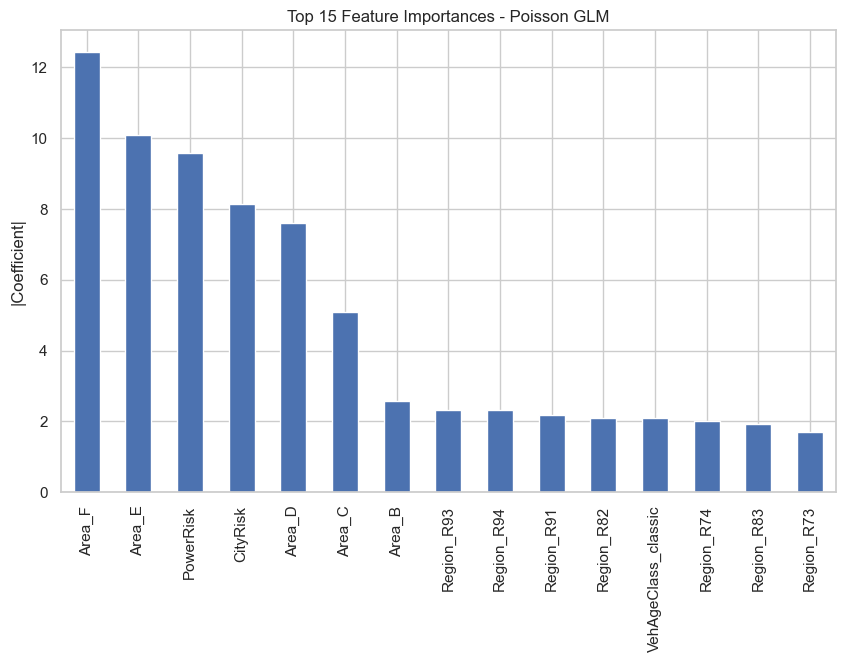

In [ ]:
# TOP 15 POISSON FEATURES

# Get absolute value of coefficients (except the constant). I remove the constant because in the Poisson model,
# the constant is linked with no variable, i.e, none variable depends on the constant so I can not get any information
# about what I am looking for now.
poisson_importance = poisson_results.params.drop("const").abs().sort_values(ascending=False)

plt.figure(figsize=(10,6))
poisson_importance.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances - Poisson GLM")
plt.ylabel("|Coefficient|")
plt.show()


<Figure size 1000x600 with 0 Axes>

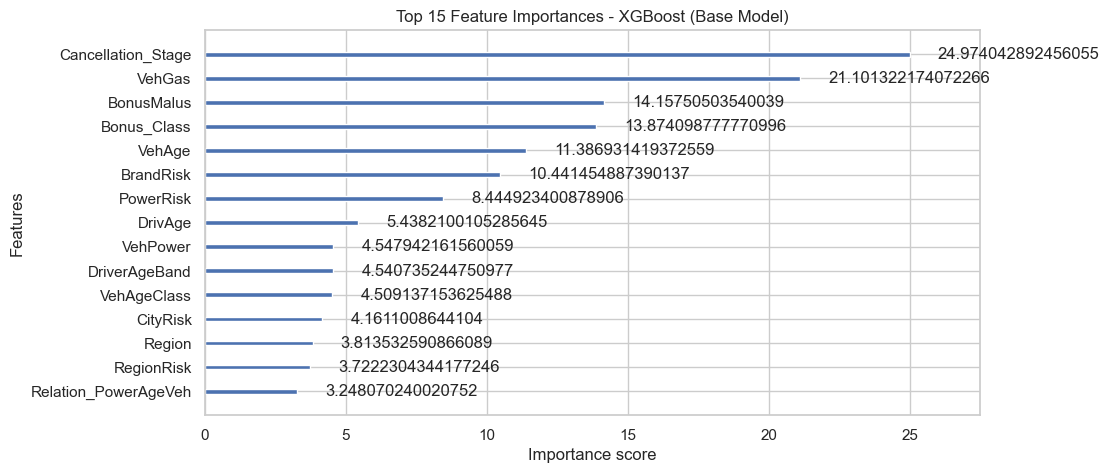

In [138]:
# TOP 15 XGBOOST BASE FEATURES

plt.figure(figsize=(10,6))
plot_importance(model_xgb, max_num_features=15, importance_type="gain")
plt.title("Top 15 Feature Importances - XGBoost (Base Model)")
plt.show()

The Poisson model focuses mainly on geographic and vehicle-related variables. The top features (Area_F, Area_E, PowerRisk, CityRisk) suggest that location and car type have the strongest effect on the expected number of claims.

This makes sense because some areas may have higher accident frequencies or specific vehicle risks.

In contrast, the XGBoost model highlights more behavioral and policy-related variables such as Cancellation_Stage, Bonus_Class and BonusMalus.  
This means XGBoost captures patterns that are not linear, for example, the relationship between driver behavior and claim frequency which the Poisson model cannot model as easily.

Overall:
- **Poisson GLM** gives clearer, interpretable relationships between predictors and claims.  
- **XGBoost** captures more complex, non-linear effects and interactions, improving accuracy.

Both models are consistent: they agree that driver behavior and risk factors (BonusMalus, Bonus_Class, and vehicle characteristics) are key predictors.

<Figure size 1000x600 with 0 Axes>

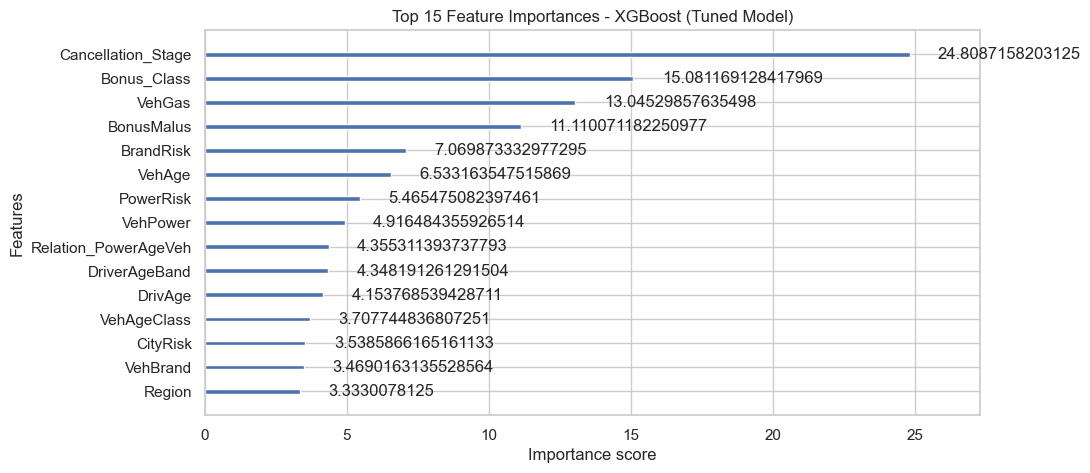

In [139]:
# TOP 15 TUNNING XGBOOST FEATURES

import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model_xgb_best, max_num_features=15, importance_type="gain")
plt.title("Top 15 Feature Importances - XGBoost (Tuned Model)")
plt.show()



The plot shows the 15 most important features for the tuned XGBoost model.
The most important one is Cancellation_Stage, meaning that the time when a policy gets cancelled or renewed has a strong impact on the number of claims.

Other key features include:
- Bonus_Class and BonusMalus, which represent the driver’s history and risk level.
- VehGas and VehPower, related to vehicle type and performance.
- BrandRisk and VehAge, which describe the car’s reliability and age.  

Features such as CityRisk, VehBrand, and Region still contribute, but their impact is smaller.

In summary, XGBoost focuses more on behavioural and vehicle-based variables rather than demographic factors.
This makes sense in a business context, as driver risk and car condition usually explain most of the claim frequency.

##### TOP 10 errors and suggestions

In [ ]:
# I am calculating the absolute error here. I calculated the residuals as the actual value minus the predicted value.
# IMPORTANT INFORMATION: In this part, I use the tunning XGBoost metrics.
test_results = test_df.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_test_pred
test_results["Error"] = test_results["Actual"] - test_results["Predicted"]
test_results["AbsError"] = test_results["Error"].abs()

# Calculating the TOP 10 errors.
top10_errors = test_results.sort_values("AbsError", ascending=False).head(10)
display(top10_errors[["IDpol", "Actual", "Predicted", "AbsError"]])


,IDpol,Actual,Predicted,AbsError
488270,3254353.0,11,0.793407,10.206593
304484,2216294.0,6,1.884800,4.115200
364437,3016883.0,4,0.069498,3.930502
613176,5044733.0,3,0.029370,2.970630
6913,20188.0,3,0.034271,2.965729
4808,10749.0,3,0.039570,2.960430
497569,4020812.0,3,0.040084,2.959916
510386,4051789.0,3,0.043562,2.956438
630041,5088156.0,3,0.045794,2.954206
331151,2264297.0,3,0.049258,2.950742


After checking the predictions on the test set, I looked at the 10 biggest errors between the predicted and real number of claims.

Most of the large errors come from policies with many claims (3 or more), while the model predicted values close to 0.
This means the model usually underestimates rare high-claim events. It is normal in count data, because most policies have 0 or 1 claim, and only a few have very high values.

Possible reasons:

The data is very unbalanced (most claims = 0).

The model does not learn well from a few extreme cases.

Some of these policies might have wrong data or special conditions (for example fleets, i.e, more than one vehicle in the same policy or accidents in a short period).

Ideas to improve:

Add new interaction features (for example, DriverAge × VehPower).

Give more weight to policies with claims > 1 during training.

For the most extreme cases like 11 or 16 claims, removing them in this case it wouldn't be a problem as there are only 4 and probably they don't follow they same patterns.

In general, the model works well for normal cases but struggles with the rare, high-claim situations.

## Business interpretation and recommendation 

Based on both the Poisson GLM and XGBoost models, we can identify the main drivers of claim frequency and how they can be used for business decisions.

**High-risk customers and policies**

Drivers with a high BonusMalus (penalty level) are more likely to have claims.

Older or classic vehicles show higher expected claim counts, possibly due to maintenance issues or higher repair costs.

Customers in some regions or cities with higher risk scores (CityRisk, RegionRisk) also tend to report more claims.

Policies with malus or neutral Bonus_Class are riskier than those with a bonus.

**Important features**

The most influential features are: BonusMalus, VehAgeClass, PowerRisk, CityRisk, and RegionRisk.

Features such as VehPower or Density have less impact, suggesting that vehicle power and population density are not strong predictors in this dataset.

**Business recommendations**

Use the predicted claim frequency to adjust premiums: higher-risk profiles should pay more to compensate for expected claims.

Encourage safer driving or renewal programs for drivers with high BonusMalus to reduce claim rates.

Investigate specific high-risk regions to understand environmental or behavioral factors increasing accidents.

Consider reviewing or limiting old or classic car policies, since they tend to show higher loss ratios.

Overall, the models provide useful insights for improving risk segmentation and pricing strategy, even if some extreme claim events remain hard to predict.

Finally, by integrating these predictive insights into pricing and policy management, the company can enhance profitability, reduce claim frequency, and improve customer segmentation.

## Final Summary

- **Objective:** Predict claim frequency using policy and driver data.
- **Best model:** XGBoost with Poisson objective (MAE = 0.097, RMSE = 0.236).
- **Key drivers:** BonusMalus, Bonus_Class, Vehicle Age, and regional risk indicators.
- **Business insights:** Older vehicles, high-penalty drivers, and high-risk areas show higher claim frequencies.
- **Next steps:** Integrate claim prediction into premium pricing, investigate extreme claims, and test model on new policy years.
